In [2]:
!pip install brevitas
!pip install onnx
!pip install onnxoptimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.6/706.6 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import brevitas.nn as qnn
from brevitas.quant import SignedBinaryWeightPerTensorConst, Int8WeightPerTensorFixedPoint
from brevitas.nn import QuantIdentity
# from brevitas.export import export_qonnx
from copy import deepcopy

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
data_dir = "./"
df_normal = pd.DataFrame(np.load(data_dir + "normal_data.npy", allow_pickle=True))
df_normal[320] = 1

df_leak = pd.DataFrame(np.load(data_dir + "leak_data.npy", allow_pickle=True))
df_leak[320] = 0

data = pd.concat([df_normal, df_leak])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print("success")

success


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# tensor 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# weight_quant = SignedBinaryWeightPerTensorConst # 평균0.4loss, accuracy=0.8
weight_quant = Int8WeightPerTensorFixedPoint

In [31]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = qnn.QuantLinear(320, 1000, bias=True, weight_quant=weight_quant)
        self.batch_norm1 = nn.BatchNorm1d(1000)

        self.layer2 = qnn.QuantLinear(1000, 128, bias=True, weight_quant=weight_quant)
        self.batch_norm2 = nn.BatchNorm1d(128)

        self.layer3 = qnn.QuantLinear(128, 64, bias=True, weight_quant=weight_quant)
        self.batch_norm3 = nn.BatchNorm1d(64)

        self.output = qnn.QuantLinear(64, 1, bias=True, weight_quant=weight_quant)
        self.relu = qnn.QuantReLU(weight_quant=weight_quant)
        self.sigmoid = qnn.QuantSigmoid(weight_quant=weight_quant)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.batch_norm1(x)

        x = self.relu(self.layer2(x))
        x = self.batch_norm2(x)

        x = self.relu(self.layer3(x))
        x = self.batch_norm3(x)

        x = self.sigmoid(self.output(x))
        return x


In [32]:
model = Model()

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)  # SGD

epochs = 500
loss_history = []
acc_history = []

In [33]:
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    predictions = (outputs > 0.5).float()
    accuracy = (predictions == y_train_tensor).float().mean().item()

    loss_history.append(loss.item())
    acc_history.append(accuracy)
    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Accuracy: {accuracy:.4f}")

Epoch 1/500 - Loss: 0.6920 - Accuracy: 0.5130
Epoch 21/500 - Loss: 0.3612 - Accuracy: 0.9066
Epoch 41/500 - Loss: 0.2868 - Accuracy: 0.9442
Epoch 61/500 - Loss: 0.2453 - Accuracy: 0.9538
Epoch 81/500 - Loss: 0.2205 - Accuracy: 0.9598
Epoch 101/500 - Loss: 0.2037 - Accuracy: 0.9624
Epoch 121/500 - Loss: 0.1903 - Accuracy: 0.9657
Epoch 141/500 - Loss: 0.1793 - Accuracy: 0.9675
Epoch 161/500 - Loss: 0.1710 - Accuracy: 0.9694
Epoch 181/500 - Loss: 0.1622 - Accuracy: 0.9724
Epoch 201/500 - Loss: 0.1555 - Accuracy: 0.9735
Epoch 221/500 - Loss: 0.1489 - Accuracy: 0.9753
Epoch 241/500 - Loss: 0.1427 - Accuracy: 0.9762
Epoch 261/500 - Loss: 0.1371 - Accuracy: 0.9780
Epoch 281/500 - Loss: 0.1315 - Accuracy: 0.9787
Epoch 301/500 - Loss: 0.1267 - Accuracy: 0.9802
Epoch 321/500 - Loss: 0.1222 - Accuracy: 0.9809
Epoch 341/500 - Loss: 0.1175 - Accuracy: 0.9814
Epoch 361/500 - Loss: 0.1137 - Accuracy: 0.9823
Epoch 381/500 - Loss: 0.1100 - Accuracy: 0.9831
Epoch 401/500 - Loss: 0.1059 - Accuracy: 0.983

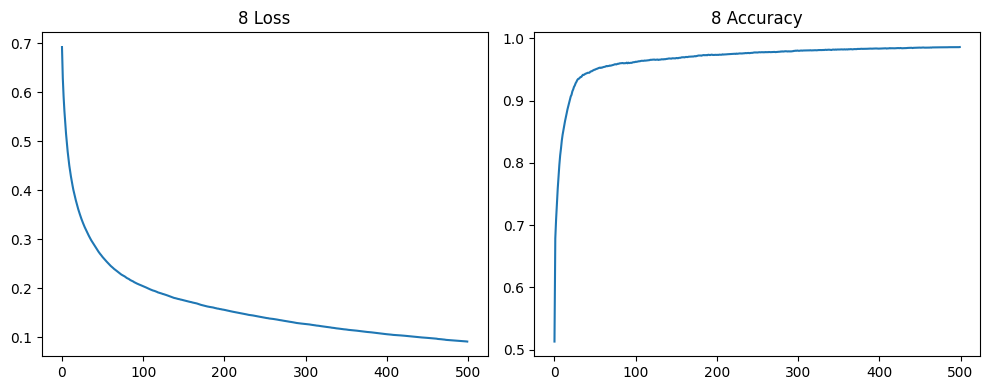

In [34]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("8 Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.title("8 Accuracy")
plt.tight_layout()
plt.show()


# 모델 내보내기

In [40]:
from copy import deepcopy
model = model.cpu()
# 모델 복사
modified_model = deepcopy(model)

from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        # 모델
        self.qnt_output = QuantIdentity(
            quant_type='binary',
            scaling_impl_type='const',
            bit_width=1, min_val=-1.0, max_val=1.0)

    def forward(self, x):
        x = (x + torch.tensor([1.0]).to(x.device)) / 2.0
        print(x.shape)
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}
        return out_final

model_for_export = CybSecMLPForExport(modified_model)
model_for_export.to(device)

CybSecMLPForExport(
  (pretrained): Model(
    (layer1): QuantLinear(
      in_features=320, out_features=1000, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
            (input_view_impl): Identity()
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              

In [39]:
from brevitas.export import export_qonnx
import onnx
import onnxoptimizer

ready_model_filename = "/plz_work.onnx"
input_shape = (1, 320)

input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
input_a = 2 * input_a - 1
scale = 1.0
input_t = torch.from_numpy(input_a * scale)
print (input_t.shape)
model_for_export.cpu()
export_qonnx(model_for_export, export_path=ready_model_filename, input_t=input_t)


torch.Size([1, 320])


ir_version: 8
producer_name: "pytorch"
producer_version: "2.6.0"
graph {
  node {
    input: "onnx::Add_0"
    input: "/Constant_output_0"
    output: "/Add_output_0"
    name: "/Add"
    op_type: "Add"
  }
  node {
    input: "/Add_output_0"
    input: "/Constant_1_output_0"
    output: "/Div_output_0"
    name: "/Div"
    op_type: "Div"
  }
  node {
    input: "/pretrained/layer1/weight_quant/export_handler/Constant_1_output_0"
    input: "/pretrained/layer1/weight_quant/export_handler/Constant_2_output_0"
    input: "/pretrained/layer1/weight_quant/export_handler/Constant_3_output_0"
    input: "/pretrained/layer1/weight_quant/export_handler/Constant_output_0"
    output: "/pretrained/layer1/weight_quant/export_handler/Quant_output_0"
    name: "/pretrained/layer1/weight_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 1
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attrib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')